In [1]:
import numpy as np
from scipy import sparse
import re
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.feature_selection import SelectFromModel
import datetime as dt
import math
from sklearn.linear_model import Lasso as Lasso_Reg
import numpy as np 
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from scipy.stats.mstats import winsorize
from sklearn.grid_search import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
ny = pd.read_csv('/Users/sarahqin/Downloads/cleaned_with_nlp_listings.csv')

In [3]:
ny.columns

Index(['id', 'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calcu

In [4]:
#ycol = ["price"]
xcol = [i for i in ny.columns if i not in "price"]
x = ny[xcol].values
#y = ny[ycol].values


In [5]:
y = ny.loc[:,'price']

In [6]:
encoded_data = pd.DataFrame({}) 

for column in ny.columns:
    if ny[column].dtype == np.dtype('object'):
        # use one-hot encoding
        encoding = pd.get_dummies(ny[column])
        encoded_data = pd.concat([encoded_data, encoding], axis=1)
    else:
        encoded_data = pd.concat([encoded_data, ny[[column]]], axis=1)

encoded_data.head(2)

,id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,...,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,2454,60,0,1.0,1.0,1,0,1,2,1.0,...,0,1,0,0,1.0,0.000000,0.000000,0.0,0.0,0.0
1,2539,100,0,8.0,8.0,1,1,0,4,1.0,...,0,1,1,0,0.0,0.222222,0.777778,0.0,0.0,0.0


In [8]:
from sklearn.preprocessing import StandardScaler, Normalizer
standard_scaler = StandardScaler()
x = standard_scaler.fit_transform(encoded_data)

# Model

In [9]:
from sklearn.pipeline import make_pipeline   
from sklearn.preprocessing import StandardScaler                                                
from sklearn.neural_network import MLPRegressor   

# split into train and test data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=100)

pipeline = make_pipeline(StandardScaler(),                                                      
                         MLPRegressor(solver='lbfgs', hidden_layer_sizes=50))                   
pipeline.fit(x_train, y_train)                                                                  
pipeline.score(x_test, y_test)

0.9999937378961243

# M1. calculate median error score to compare different model's performance

Text(0.5,1,'Performances')

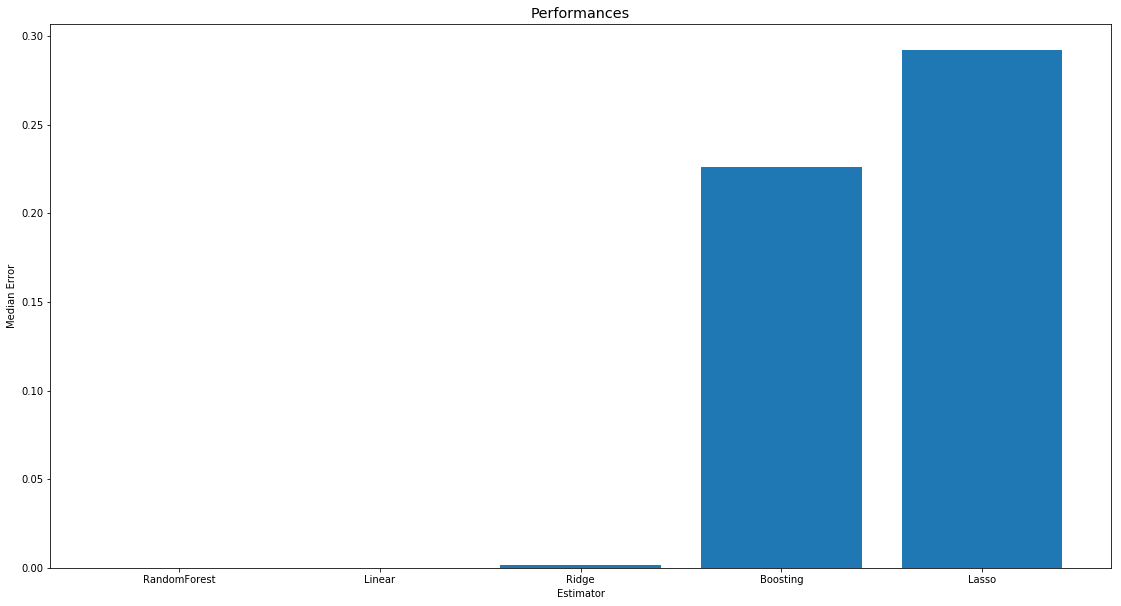

In [10]:
rs = 1

ests_labels = np.array(['Linear', 'Ridge', 'Lasso','RandomForest', 'Boosting'])

ests = [ Lin_Reg(), Ridge_Reg(),
        Lasso_Reg(),RandomForestRegressor(), GradientBoostingRegressor()]

errvals = np.array([])

for e in ests:
    e.fit(x_train, y_train)
    prediction = e.predict(x_test)
    this_err = metrics.median_absolute_error(y_test, prediction)
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(19,10))
plt.bar(pos, errvals[srt], align='center')
plt.style.use('ggplot')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Error')
plt.title('Performances')

Random Forest & Linear (or even Ridge) has the lowest error, Lasso has highest error

# M2. Tuning

In [11]:
def optimize(clf, parameters, x, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(x, y)

    best = gs.best_estimator_
    return best

In [12]:
ridge =  Ridge_Reg()
ridge.fit(x_train, y_train)
parameters = {"alpha": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
ridge2 = optimize(ridge, parameters, x_train, y_train, n_jobs=10, n_folds=5, score_func=None)

best_ridge = Ridge_Reg(alpha = ridge2.alpha)
best_ridge.fit(x_train, y_train)


print('Before cross-validation, Ridge Score:', ridge.score(x_test, y_test), '\n')

print('Alpha:', ridge2.alpha) 

print( 'After cross-validation,Ridge Score:', best_ridge.score(x_test, y_test))

Before cross-validation, Ridge Score: 0.9999999986245406 

Alpha: 0.0001
After cross-validation,Ridge Score: 1.0


In [13]:
booster =  GradientBoostingRegressor()

booster.fit(x_train, y_train)


parameters = {"max_depth": [1, 3, 5, 8], 'learning_rate': [0.1, 0.15, 0.2], 'max_features': [0.2, 0.4, 0.6, 0.8]}
booster2 = optimize(booster, parameters, x_train, y_train, n_jobs=10, n_folds=5, score_func=None)

best_booster = GradientBoostingRegressor(max_depth = booster2.max_depth, max_features = booster2.max_features, min_samples_leaf = booster2.min_samples_leaf)
best_booster.fit(x_train, y_train)

print ('Before cross-validation,', booster.score(x_test, y_test), '\n')
print ('Max Features:', booster2.max_features)
print ('Max Depth:', booster2.max_depth)
print ('Learning Rate:', booster2.learning_rate)
print ('After cross-validation,  Gradient Boosting Score:', best_booster.score(x_test, y_test))

Before cross-validation, 0.9993807686062952 

Max Features: 0.8
Max Depth: 1
Learning Rate: 0.2
After cross-validation,  Gradient Boosting Score: 0.9846474857523255


In [14]:
forest =  RandomForestRegressor()

forest.fit(x_train, y_train)

parameters ={"max_depth": [3, 5, 8, 10, 12], 'max_features': [0.2, 0.4, 0.6, 0.8], 'min_samples_leaf': [2, 5, 8, 12]}
forest2 = optimize(forest, parameters, x_train, y_train, n_jobs=10, n_folds=5, score_func=None)

best_forest = RandomForestRegressor(max_depth = forest2.max_depth, max_features = forest2.max_features, min_samples_leaf = forest2.min_samples_leaf)
best_forest.fit(x_train, y_train)

                   
print('Before cross-validation, Random Forest Score:', forest.score(x_test, y_test), '\n')

print('Max Features:', forest2.max_features) 
print ('Max Depth:', forest2.max_depth)
print ('Min Samples per Leaf:', forest2.min_samples_leaf)

print( 'After cross-validation, Random Forest Score:', forest.score(x_test, y_test))


Before cross-validation, Random Forest Score: 0.9870645091698238 

Max Features: 0.8
Max Depth: 12
Min Samples per Leaf: 2
After cross-validation, Random Forest Score: 0.9870645091698238


# M3. Compare to Linear Regression

In [15]:
def closer_score(model):
    
    clf = Lin_Reg()
    clf.fit(x_train, y_train)
    
    adv = model
    adv.fit(x_train, y_train)
 
    lin_predict = clf.predict(x_test)
    adv_predict = adv.predict(x_test)
    y_test1 = pd.DataFrame(y_test)

    y_test1.columns = ['price']
    y_test1['lin_predict'] = lin_predict
    y_test1['adv_predict'] = adv_predict
    
    y_test1['score'] = 0.0
    mask = y_test1.loc[abs(y_test1['price'] - y_test1['adv_predict']) < abs(y_test1['price'] - y_test1['lin_predict'])].index
    y_test1.loc[mask,'score'] = 1.0
    score = np.mean(y_test1.score)
    return score

In [16]:
print('Ridge is better ' + str(round(closer_score(best_ridge), 3)) + '% of the time') 
print ('Random Forest is better ' + str(round(closer_score(best_forest), 3)) + '% of the time')
print ('Gradient Boosting is better ' + str(round(closer_score(best_booster), 3)) + '% of the time')

Ridge is better 0.0% of the time
Random Forest is better 0.019% of the time
Gradient Boosting is better 0.0% of the time


ok....

# M4. Go with Random Forest